In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Conv2D, MaxPool2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical

# The Why

Out of the two presentations I did for part one of the Capstone project, I opted to go for the health inspection scores provided by the City of Austin's Health & Human Services department.

My goal is to basically do a cluster map to pinpoint any organization that handles food, and has had a failing health score multiple times.  I have a few desirable elements and challengesfor this that I don't know how to do or handle yet, such as:

I'd like to do the clusters over an overlay of a map of Austin.

I have 3 years worth of data.  Not sure if that's too much.  To overcome the idea that it's too much, I can focus on just the failing scores and omit the passing scores.

The data clean up was pretty easy.  I'll outline various clean up chores I had to do as this Jupyter Notebook progresses.



In [2]:
#Bring in the file.
df=pd.read_csv("Restaurant_Inspection_Scores.csv") #delimiter="/")

In [11]:
dirtiest=df[df.Score <=50]

In [12]:
dirtiest

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
2867,Crawfish Shack and Oyster Bar,78728,06/16/2016,45,"2013 W WELLS BRANCH PKWY\nAUSTIN, TX 78728\n",10037846,Routine Inspection
14848,Ichiban at Austin,78757,10/23/2015,36,"7310 BURNET RD\nAUSTIN, TX 78757\n(30.349328, ...",10215188,Routine Inspection
15463,Joy East,78741,02/26/2015,50,"2410 E RIVERSIDE DR\nAUSTIN, TX 78741\n(30.236...",10970056,Routine Inspection
16751,Los Potrillos Restaurant,78753,04/11/2016,50,"9120 N IH 35 SVRD SB\nAUSTIN, TX 78753\n(30.35...",10796431,Routine Inspection
17451,Mikado Ryotei,78758,12/16/2016,50,"9033 RESEARCH BLVD NB Unit 100\nAUSTIN, TX 787...",10617884,Routine Inspection
20466,Polvo's Restaurant & Bar,78704,12/23/2015,45,"2004 S 1ST ST\nAUSTIN, TX 78704\n(30.245099, -...",2801085,Routine Inspection
24487,Taqueria Arandinas,78741,12/12/2014,50,"2100 E RIVERSIDE DR\nAUSTIN, TX 78741\n(30.240...",2801526,Routine Inspection


In [20]:
dirtiest.groupby(by=["Facility ID"], axis=1)

In [4]:
#Examine the description
df.describe()

,Score,Facility ID
count,25562.000000,2.556200e+04
mean,91.276465,7.735905e+06
std,7.508453,3.869482e+06
min,36.000000,2.800004e+06
25%,87.000000,2.802304e+06
50%,93.000000,1.022271e+07
75%,97.000000,1.092674e+07
max,100.000000,1.174516e+07


In [5]:
#Look at nulls.
df.isnull().sum()

Restaurant Name        0
Zip Code               0
Inspection Date        0
Score                  0
Address                0
Facility ID            0
Process Description    0
dtype: int64

# Clean up the Zip Code
I need to transform it from an object to an int.  Zip Code is important because I plan on deleting the Address column as the data in Address can be found in several other columns, namely Facility ID and Zip Code.

In [6]:
df.dtypes

Restaurant Name        object
Zip Code               object
Inspection Date        object
Score                   int64
Address                object
Facility ID             int64
Process Description    object
dtype: object

In [7]:
df.drop(["Address"], axis=1, inplace=True)
#Dropping address because I already have zip code, restaurant name and facility ID.

In [8]:
#I see Zip Code is kind of funky.  I'll need to clean Zip Code up.
#I actually found out Zip Code was funky when trying to change it from an object to an int.
df.sort_values(["Zip Code"], ascending=False)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
16541,MN - Market Express,as 78653,06/20/2017,92,11632199,Routine Inspection
10096,Circle A,Hwy 290 E\nAustin TX 78723,03/16/2016,76,2803780,Routine Inspection
9431,Circle A,Hwy 290 E\nAustin TX 78723,08/18/2015,90,2803780,Routine Inspection
10097,Circle A,Hwy 290 E\nAustin TX 78723,02/25/2015,82,2803780,Routine Inspection
9808,Circle A,Hwy 290 E\nAustin TX 78723,12/14/2016,97,2803780,Routine Inspection
9418,Circle A,Hwy 290 E\nAustin TX 78723,06/30/2017,90,2803780,Routine Inspection
18108,Mesa Mart,78759,04/29/2016,96,2804064,Routine Inspection
1966,Wendy's #W129/11274,78759,08/22/2017,88,11115872,Routine Inspection
18093,Marco's Pizza,78759,03/10/2015,97,10905433,Routine Inspection
1965,Walgreen's #04134,78759,05/13/2015,93,2803712,Routine Inspection


In [9]:
#Remove weird strings in Zip Code.  
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('6\nAustin, TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('Hwy 290 E\nAustin TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('as'))

In [10]:
df["Zip Code"] = df["Zip Code"].apply(pd.to_numeric, errors='coerce')
# #Made it into a float, when I wanted an int.

In [11]:
df.head(3) #Checking to see if it visually looks correct.

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,Routine Inspection


In [12]:
df.dtypes  #Now checking to see if it is correct.  Says it's an int: mission accomplished.

Restaurant Name        object
Zip Code                int64
Inspection Date        object
Score                   int64
Facility ID             int64
Process Description    object
dtype: object

# Clean up the Process Description
 I want to transform the various process descriptions into dummies, so I can eventually use the groupby feature (possibly) or to break the data down into smaller bits so I can model it.

In [616]:
#df.head(3)

# Clean up the Inspection Date

Inspection date is a string.  I need to make it into an int.  I also want to split the dates up, as I might want to focus on specific years or months, or just have the data broken up so I can play with it.  

Maybe some years were more horrible for food inspection reports than others?  Or are there more failed food inspections as more restaurants enter into the review process?

In [13]:
#Break up the Inspection Date into 3 columns.
df["Month"]=df["Inspection Date"].map(lambda x: x.split("/")[0])
df["Year"]=df["Inspection Date"].map(lambda x: x.split("/")[2])
df["Day"]=df["Inspection Date"].map(lambda x: x.split("/")[1])

In [14]:
#Check the work.
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection,08,2015,19
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection,04,2015,02
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,Routine Inspection,02,2015,09


In [15]:
#Make my months, day and years into ints than strings.
df['Month'] = df['Month'].astype(str).astype(int)
df['Day'] = df['Day'].astype(str).astype(int)
df['Year'] = df['Year'].astype(str).astype(int)

In [16]:
#Check the work.
df.dtypes

Restaurant Name        object
Zip Code                int64
Inspection Date        object
Score                   int64
Facility ID             int64
Process Description    object
Month                   int64
Year                    int64
Day                     int64
dtype: object

In [17]:
df.sort_values(["Score"], axis=0, ascending=True)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day
14848,Ichiban at Austin,78757,10/23/2015,36,10215188,Routine Inspection,10,2015,23
20466,Polvo's Restaurant & Bar,78704,12/23/2015,45,2801085,Routine Inspection,12,2015,23
2867,Crawfish Shack and Oyster Bar,78728,06/16/2016,45,10037846,Routine Inspection,6,2016,16
15463,Joy East,78741,02/26/2015,50,10970056,Routine Inspection,2,2015,26
17451,Mikado Ryotei,78758,12/16/2016,50,10617884,Routine Inspection,12,2016,16
24487,Taqueria Arandinas,78741,12/12/2014,50,2801526,Routine Inspection,12,2014,12
16751,Los Potrillos Restaurant,78753,04/11/2016,50,10796431,Routine Inspection,4,2016,11
23817,Taqueria Chapala # 5,78741,06/04/2015,51,11252521,Routine Inspection,6,2015,4
15790,La Casita Mexican Restaurant,78757,07/07/2016,53,10609544,Routine Inspection,7,2016,7
16185,La Catedral Del Marisco,78702,02/27/2015,53,11077157,Routine Inspection,2,2015,27


# Data Exploration - in process!

In [18]:
df.columns

Index(['Restaurant Name', 'Zip Code', 'Inspection Date', 'Score',
       'Facility ID', 'Process Description', 'Month', 'Year', 'Day'],
      dtype='object')

In [625]:
# df["Dirties"] =df["Score"]

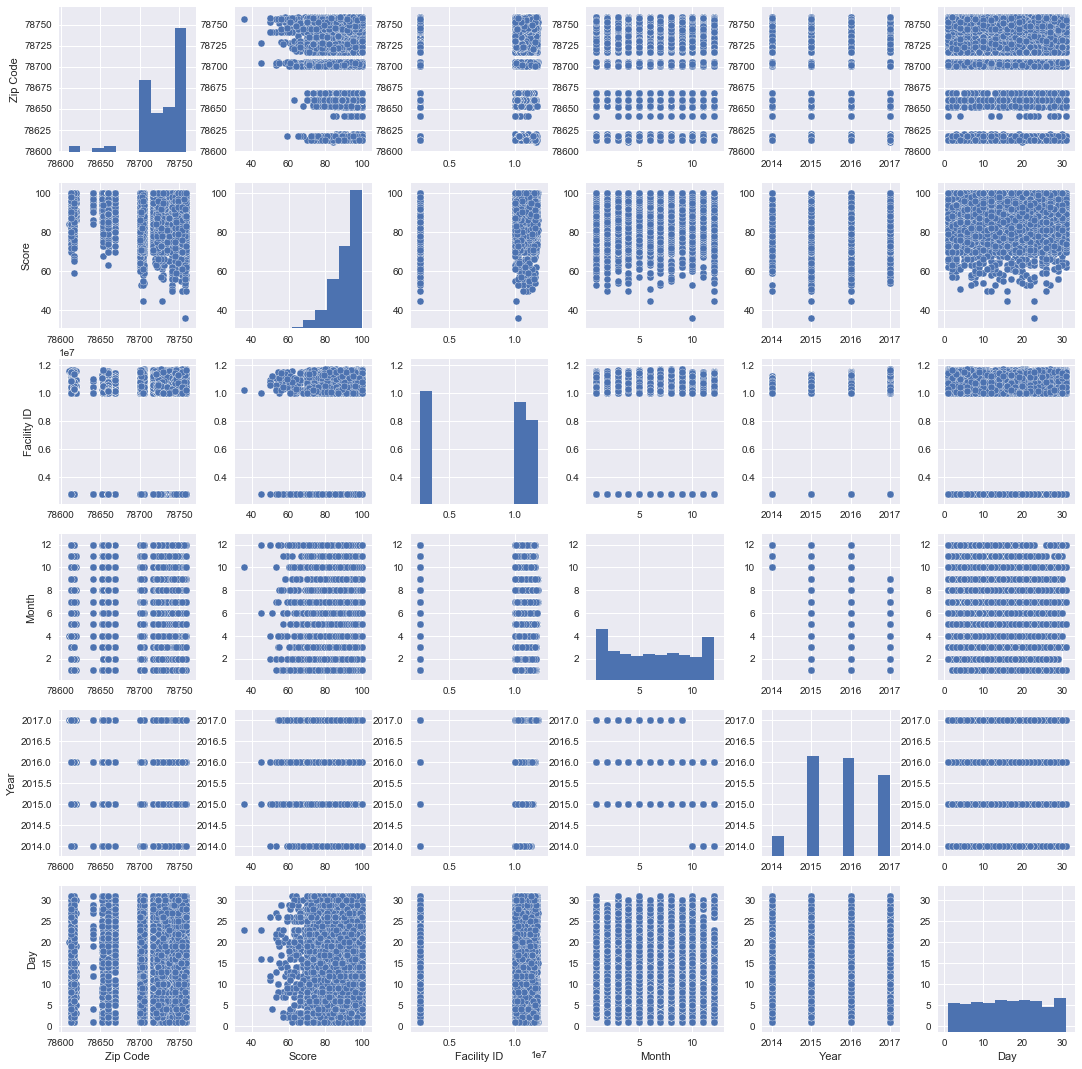

In [19]:
sns.pairplot(df)

In [ ]:


# df["Dirties"] =np.where((df["Dirties"]<=29) & (df["Dirties"]>=10),1,df["Dirties"])
# #Less than 30

# df["Dirties"] =np.where((df["Dirties"]<=39) & (df["Dirties"]>=30),2,df["Dirties"])
# #30 scores

# df["Dirties"] =np.where((df["Dirties"]<=49) & (df["Dirties"]>=40),3,df["Dirties"])
# #40 scores

# df["Dirties"] =np.where((df["Dirties"]<=59) & (df["Dirties"]>=50),4,df["Dirties"])
# #50 scores

# df["Dirties"] =np.where((df["Dirties"]<=69) & (df["Dirties"]>=60),5,df["Dirties"])
# #60 scores

# df["Dirties"] =np.where(df["Dirties"]==70,6, df["Dirties"])
# #Just 70 scores

# df["Dirties"] =np.where(df["Dirties"]>=71,7,df["Dirties"])

In [639]:
# df.drop(["Dirties"], inplace=True, axis=1)

In [292]:
# df_train=df.corr()
# print (df_train['Dirties'].sort_values(ascending=False)[:20], '\n')

Dirties        1.000000
Score          0.390043
Year           0.010385
Month          0.003580
Day            0.002357
Facility ID   -0.001348
Zip Code      -0.006065
Name: Dirties, dtype: float64 



In [25]:
dirties=df[df.Score <=70]

In [27]:
dirties.shape

(339, 10)

In [26]:
dirties.head()

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day,Dirties
85,Tyson's Tacos,78751,01/09/2015,70,10933597,Routine Inspection,1,2015,9,True
320,Viva Meat Market,78758,07/18/2016,63,10769105,Routine Inspection,7,2016,18,False
640,Viva Meat Market,78758,12/29/2015,56,10769105,Routine Inspection,12,2015,29,False
685,"Verts Mediterranean Grill, Inc.",78723,02/17/2016,70,10985121,Routine Inspection,2,2016,17,True
740,Vince Young Steakhouse,78701,09/17/2015,70,10483507,Routine Inspection,9,2015,17,True


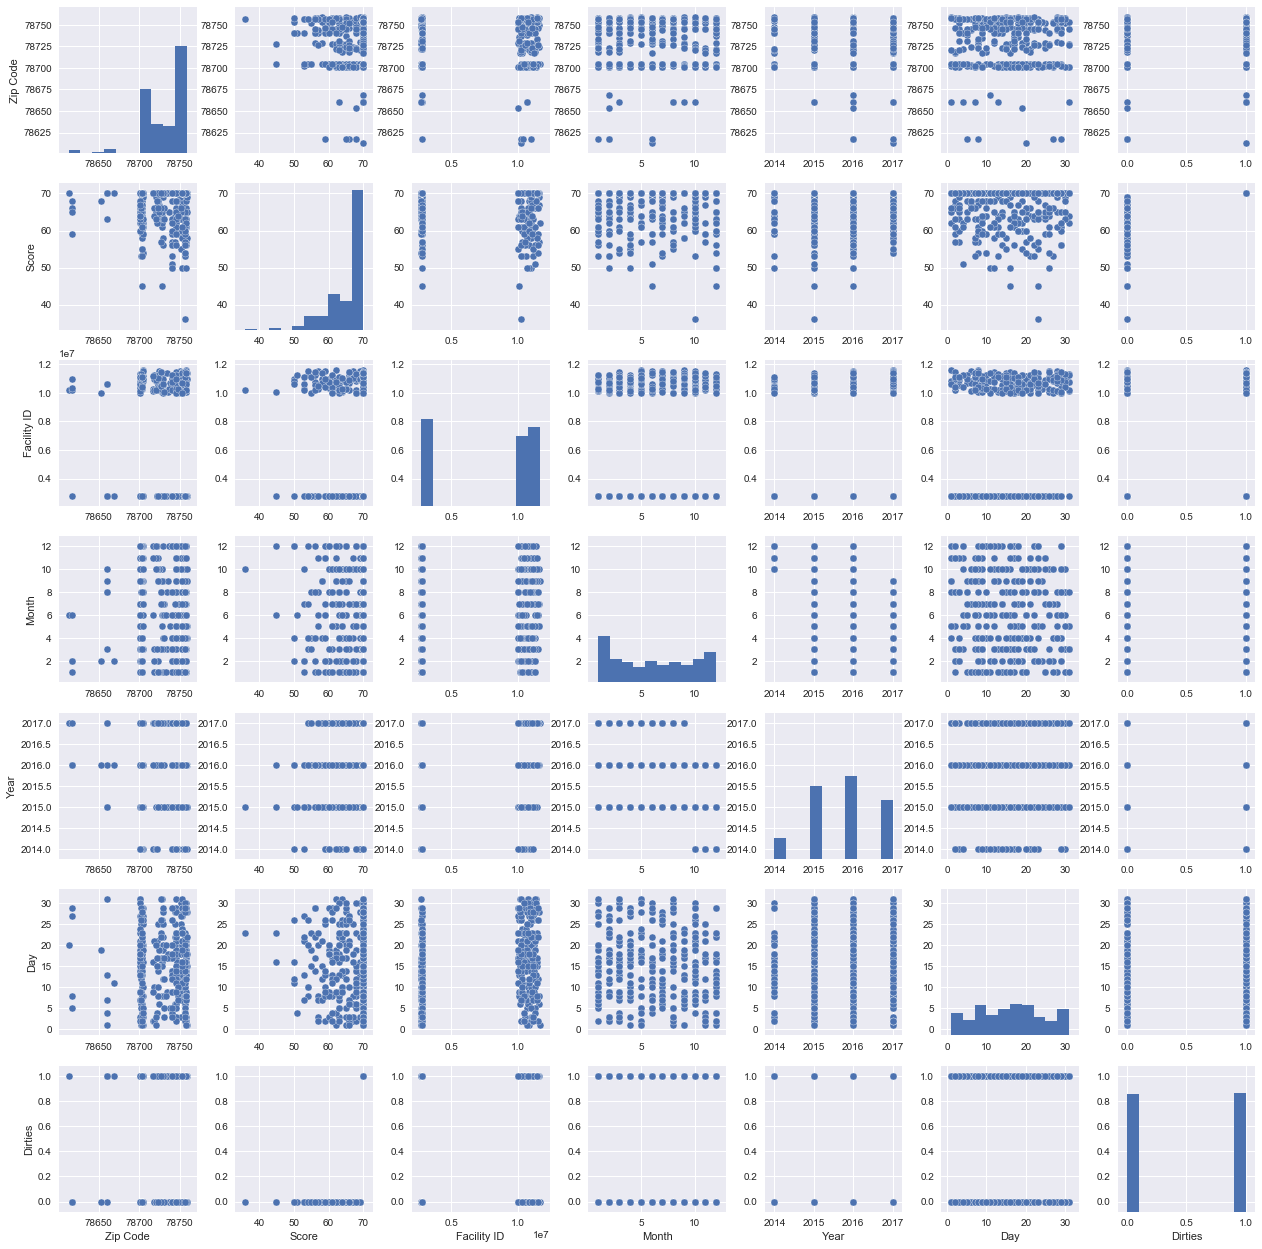

In [28]:
sns.pairplot(dirties)

In [31]:
dirties

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day,Dirties
85,Tyson's Tacos,78751,01/09/2015,70,10933597,Routine Inspection,1,2015,9,True
320,Viva Meat Market,78758,07/18/2016,63,10769105,Routine Inspection,7,2016,18,False
640,Viva Meat Market,78758,12/29/2015,56,10769105,Routine Inspection,12,2015,29,False
685,"Verts Mediterranean Grill, Inc.",78723,02/17/2016,70,10985121,Routine Inspection,2,2016,17,True
740,Vince Young Steakhouse,78701,09/17/2015,70,10483507,Routine Inspection,9,2015,17,True
920,Viva Food Mart - Taqueria,78758,05/08/2017,70,11570417,Routine Inspection,5,2017,8,True
1026,Twin Creeks Country Club,78613,06/20/2017,70,10197578,Routine Inspection,6,2017,20,True
1166,Which Wich,78701,10/09/2015,64,10976306,Routine Inspection,10,2015,9,False
1682,Walton's Fancy & Staple,78701,11/21/2014,70,10196030,Routine Inspection,11,2014,21,True
2189,Zen Restaurant,78757,08/10/2017,70,2801525,Routine Inspection,8,2017,10,True


In [33]:
features=["Facility ID"]
X=pd.DataFrame(dirties, columns=features)
y=dirties["Score"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
print("X_train", X_train.shape, "X_test", X_test.shape)

print("y_train", y_train.shape, "y_test", y_test.shape)

X_train (254, 1) X_test (85, 1)
y_train (254,) y_test (85,)


In [39]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [40]:
gc = GradientBoostingClassifier()
gc_params = {
    "n_estimators": [75, 100, 125],
    "max_depth" : range (2,5),
    "max_features" : ["auto", "log2", None]
    }
gc_model = GridSearchCV(gc, param_grid=gc_params)
gc_model.fit(X_train, y_train)
print('best score', gc_model.best_score_)
print('best params', gc_model.best_params_)
print('test score', gc_model.score(X_test, y_test))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


best score 0.303149606299
best params {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 75}
test score 0.258823529412


In [41]:
#ADA

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [25, 50, 100],
    'base_estimator__max_depth': range(2,5),
    'base_estimator__max_features': ['auto', 'log2', None]
}
ada_model = GridSearchCV(ada, param_grid=ada_params)
ada_model.fit(X_train, y_train)
print('best score', ada_model.best_score_)
print('best params', ada_model.best_params_)
print('test score', ada_model.score(X_test, y_test))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


best score 0.468503937008
best params {'base_estimator__max_depth': 2, 'base_estimator__max_features': 'auto', 'n_estimators': 50}
test score 0.329411764706


In [43]:
knn = KNeighborsClassifier(n_neighbors=5, p=1)
knn.fit(X_train, y_train)
knn_train_score=knn.score(X_train, y_train)
knn_test_score=knn.score(X_test, y_test)
print("This is my train score:",knn_train_score)
print("This is my test score:", knn_test_score)

This is my train score: 0.531496062992
This is my test score: 0.341176470588


In [69]:
from mpl_toolkits.basemap import Basemap

/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


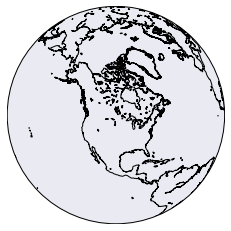

In [70]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
              resolution='l', area_thresh=1000.0)
 
map.drawcoastlines()
 
plt.show()

In [75]:
# m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
#       urcrnrlat=49, projection='lcc', lat_1=30.307182,
#       lon_0= -97.755996, resolution='h', area_thresh=10000)

In [77]:
m = Basemap(lat_1=30.307182, lon_0= -97.755996)

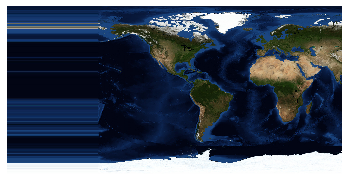

In [78]:
m.bluemarble()


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


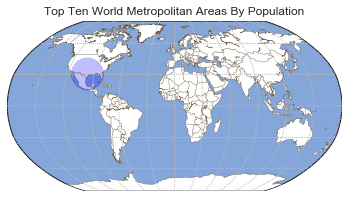

In [81]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

# lon_0 is central longitude of robinson projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0,resolution='c')
#set a background colour
m.drawmapboundary(fill_color='#85A6D9')

# draw coastlines, country boundaries, fill continents.
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawcountries(color='#6D5F47', linewidth=.4)

# draw lat/lng grid lines every 30 degrees.
m.drawmeridians(np.arange(-180, 180, 30), color='#bbbbbb')
m.drawparallels(np.arange(-90, 90, 30), color='#bbbbbb')

# lat/lon coordinates of top ten world cities
lats = [30.3]
lngs = [-97.76]
#populations = [32.45,20.55,20.45,19.75,19.2,18.9,18.85,18.6,17.375,16.65] #millions

# compute the native map projection coordinates for cities
x,y = m(lngs,lats)

#scale populations to emphasise different relative pop sizes
s_populations = [p * p for p in populations]

#scatter scaled circles at the city locations
m.scatter(
    x,
    y,
    s=s_populations, #size
    c='blue', #color
    marker='o', #symbol
    alpha=0.25, #transparency
    zorder = 2, #plotting order
    )

# # plot population labels of the ten cities.
# for population, xpt, ypt in zip(populations, x, y):
#     label_txt = int(round(population, 0)) #round to 0 dp and display as integer
#     plt.text(
#         xpt,
#         ypt,
#         label_txt,
#         color = 'blue',
#         size='small',
#         horizontalalignment='center',
#         verticalalignment='center',
#         zorder = 3,
#         )
        
#add a title and display the map on screen
plt.title('Top Ten World Metropolitan Areas By Population')
plt.show()

In [248]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

X, y = make_blobs(
    n_samples    =  200, 
    centers      =  3, 
    n_features   =  2,
    random_state =  364
)


dirty_cluster = pd.DataFrame(X, columns=['Zip Code', 'Score'])
dirty_cluster.head()


,Zip Code,Score
0,-5.716626,7.865418
1,-2.081026,-7.708825
2,-8.057452,-7.008271
3,-9.571572,-7.820384
4,-9.144392,-6.988266


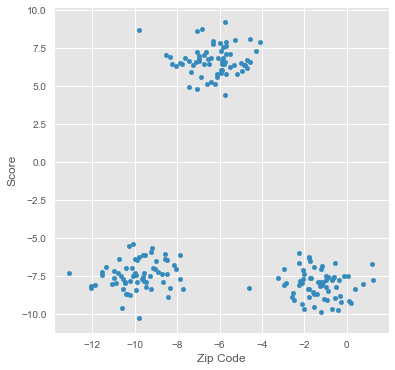

In [249]:
dirty_cluster.plot(kind="scatter", x="Zip Code", y="Score", figsize=(6, 6))

In [250]:
model = KMeans(n_clusters=3, random_state=0).fit(dirty_cluster)

predicted = model.labels_
centroids = model.cluster_centers_

print("Predicted clusters to points: ", predicted)
print("Location of centroids: ")
print(centroids)

In [252]:
dirty_cluster['predicted'] = predicted
dirty_cluster.head()

,Zip Code,Score,predicted
0,-5.716626,7.865418,1
1,-2.081026,-7.708825,2
2,-8.057452,-7.008271,0
3,-9.571572,-7.820384,0
4,-9.144392,-6.988266,0


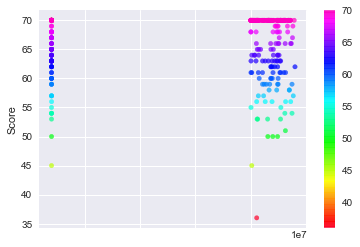

In [50]:
plt.figure(figsize=(7,7))
dirties.plot(x="Facility ID", y="Score", kind="scatter", c=dirties['Score'], cmap='gist_rainbow', alpha=.7)
#plt.scatter(centroids[:,:1], centroids[:,1:], marker='x', s=150, alpha=.7, c=range(0,3), cmap='gist_rainbow')

In [233]:
inertia = model.inertia_
sil_score = silhouette_score(df, predicted, metric='euclidean')

print('Inertia          = ', inertia)
print('Silhouette score = ', sil_score)

Inertia          =  408.042323215
Silhouette score =  0.822362200848


In [262]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [1]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

NameError: name 'make_blobs' is not defined

For n_clusters = 2 The average silhouette_score is : 0.704978749608


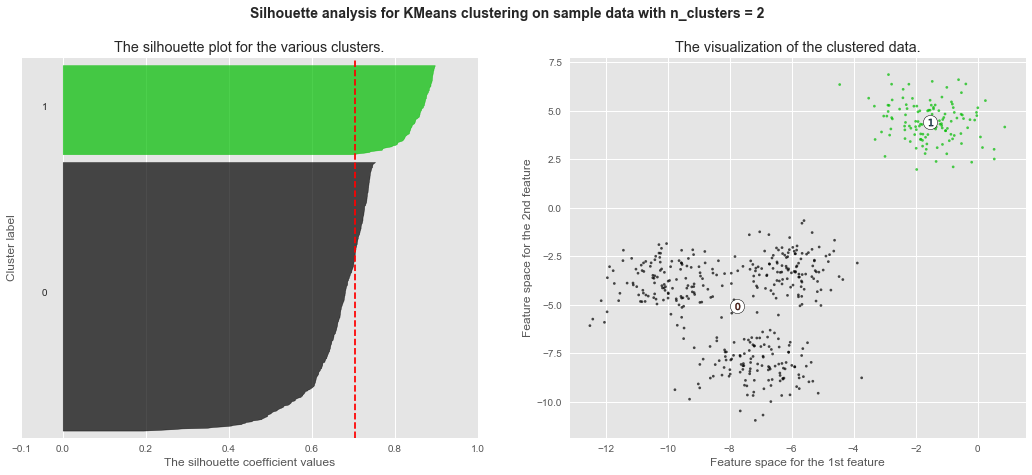

For n_clusters = 3 The average silhouette_score is : 0.588200401213


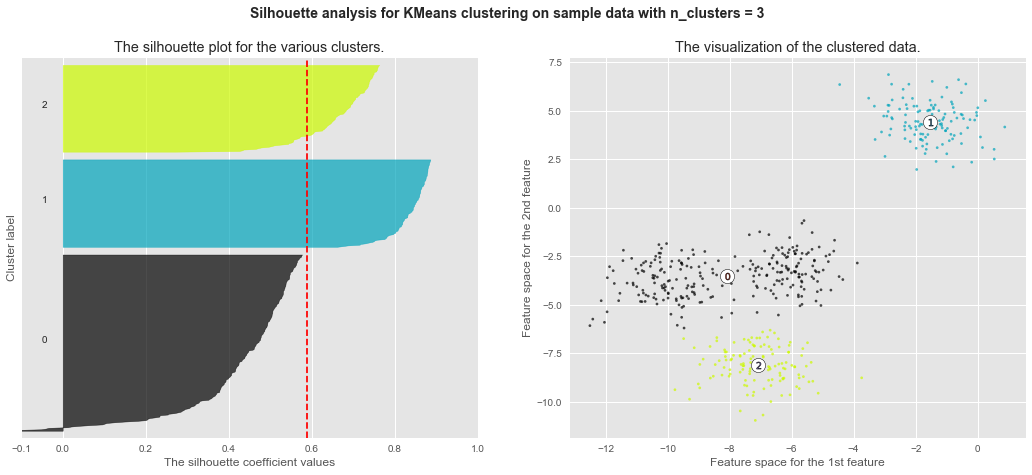

For n_clusters = 4 The average silhouette_score is : 0.650518663273


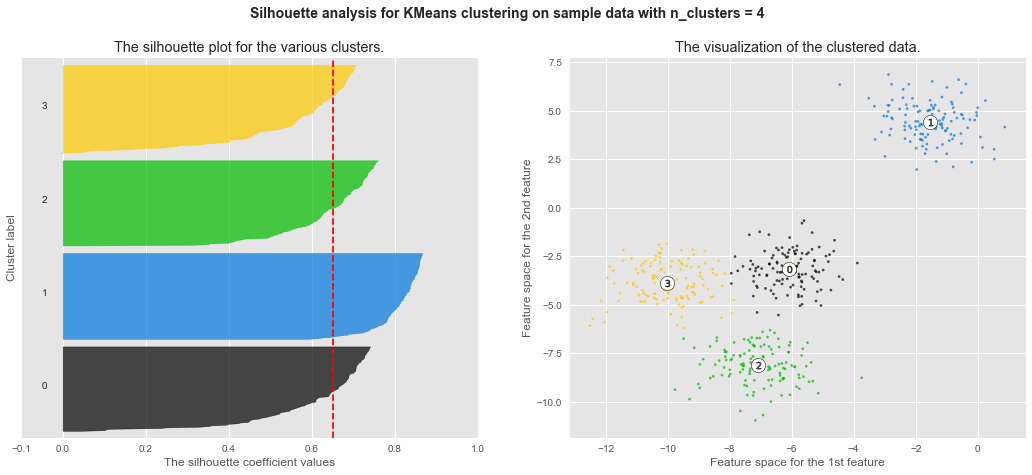

For n_clusters = 5 The average silhouette_score is : 0.563764690262


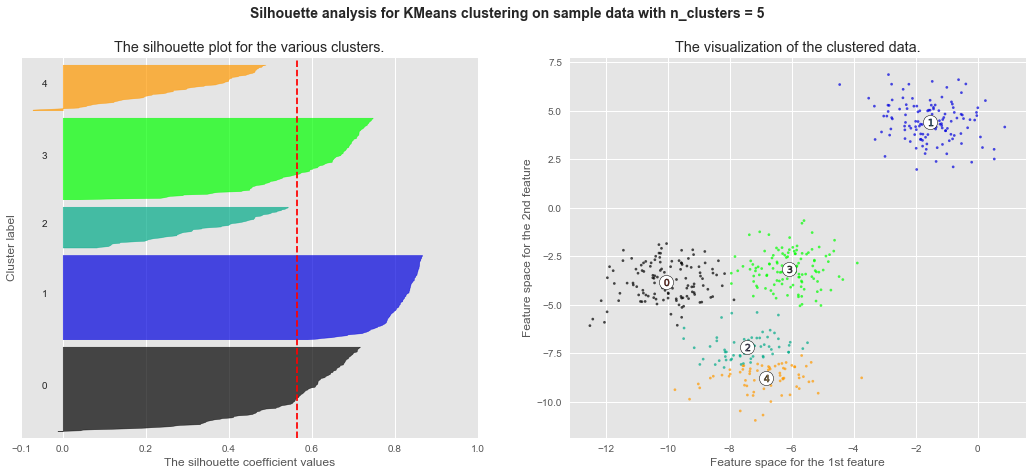

For n_clusters = 6 The average silhouette_score is : 0.450466629437


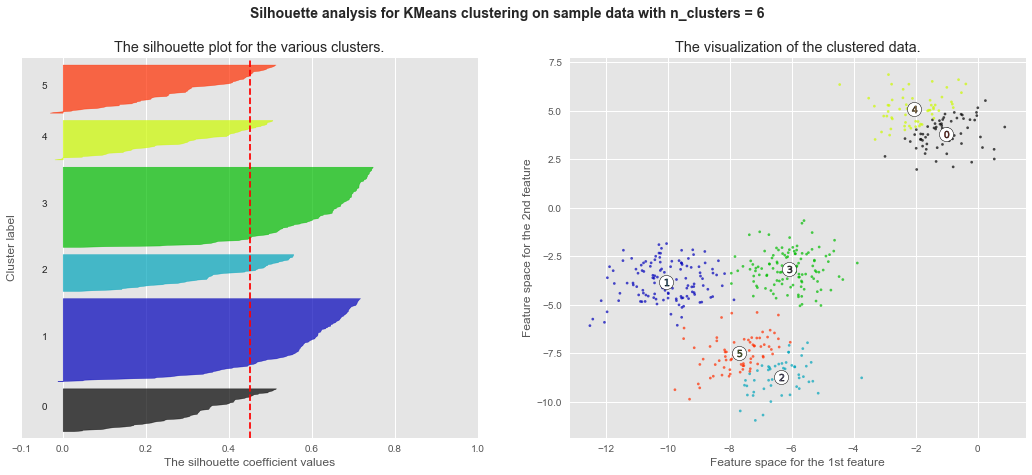

In [265]:

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
                # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [269]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[ 0.99244289  0.00755711]
[ 6.30061232  0.54980396]


Estimated number of clusters: 2
Homogeneity: 0.539
Completeness: 0.788
V-measure: 0.640
Adjusted Rand Index: 0.533
Adjusted Mutual Information: 0.538
Silhouette Coefficient: 0.449


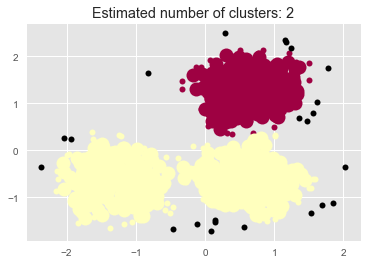

In [275]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=1975, )

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [233]:
df.groupby(by="Score").count()
#titanic.groupby("IsReverend").count()

,Restaurant Name,Zip Code,Inspection Date,Address,Facility ID,Process Description,Month,Year,Day,Dirties
Score,,,,,,,,,,
36,1,1,1,1,1,1,1,1,1,1
45,2,2,2,2,2,2,2,2,2,2
50,4,4,4,4,4,4,4,4,4,4
51,1,1,1,1,1,1,1,1,1,1
53,5,5,5,5,5,5,5,5,5,5
54,5,5,5,5,5,5,5,5,5,5
55,3,3,3,3,3,3,3,3,3,3
56,6,6,6,6,6,6,6,6,6,6
57,6,6,6,6,6,6,6,6,6,6


In [232]:
Score_Group

# Kenser and Tensor Flow

In [641]:
# dirties.columns
# dirties["Score"] = df["Score"]

In [643]:
# #df["Pass_Fail"]=np.where(df["Pass_Fail"]>=71,0,df["Pass_Fail"]) #Passing score=0
# df["Pass_Fail"] = df["Pass_Fail"].apply(lambda x: 1 if x >= 71 else 0)


In [645]:
# y=df["Pass_Fail"]#Pass or fail.  70 and below is a fail, 71 and above is a pass.

In [646]:
# y.shape

(25562,)

In [647]:
# #features=["Zip Code", "Year", "Facility ID"]
# features=["Facility ID"]
# X=pd.DataFrame(df, columns=features)

In [51]:
model=Sequential()

In [55]:
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation="relu"))

In [56]:
model.add(Dense(1, activation="sigmoid"))

In [57]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [656]:
model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=5, batch_size=50)

Train on 19171 samples, validate on 6391 samples
Epoch 1/5
19171/19171 [==============================] - 2s 121us/step - loss: 0.6085 - acc: 0.9649 - val_loss: 0.5310 - val_acc: 0.9865
Epoch 2/5
19171/19171 [==============================] - 2s 92us/step - loss: 0.4689 - acc: 0.9868 - val_loss: 0.4129 - val_acc: 0.9865
Epoch 3/5
19171/19171 [==============================] - 2s 88us/step - loss: 0.3676 - acc: 0.9868 - val_loss: 0.3270 - val_acc: 0.9865
Epoch 4/5
19171/19171 [==============================] - 2s 91us/step - loss: 0.2938 - acc: 0.9868 - val_loss: 0.2642 - val_acc: 0.9865
Epoch 5/5
19171/19171 [==============================] - 2s 89us/step - loss: 0.2396 - acc: 0.9868 - val_loss: 0.2178 - val_acc: 0.9865


In [58]:
model.predict(X_test)

array([[ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327564],
       [ 0.49327499],
       [ 0.49635676],
       [ 0.49327576],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327493],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327505],
       [ 0.49327588],
       [ 0.49635676],
       [ 0.49327505],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327534],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327517],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327511],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327528],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327517],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327517],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327505],
       [ 0.49635676],
       [ 0.49635676],
       [ 0.49327493],
       [ 0

In [59]:
gc = GradientBoostingClassifier()
gc_params = {
    "n_estimators": [75, 100, 125],
    "max_depth" : range (2,5),
    "max_features" : ["auto", "log2", None]
    }
gc_model = GridSearchCV(gc, param_grid=gc_params)
gc_model.fit(X_train, y_train)
print('best score', gc_model.best_score_)
print('best params', gc_model.best_params_)
print('test score', gc_model.score(X_test, y_test))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


best score 0.303149606299
best params {'max_depth': 2, 'max_features': 'auto', 'n_estimators': 75}
test score 0.258823529412


In [60]:

y.shape

(339,)

In [140]:
dirties["Score"].value_counts()

70    170
63     20
65     16
68     14
64     13
66     12
61     11
60     10
59     10
62     10
67      8
69      8
57      6
56      6
54      5
53      5
58      4
50      4
55      3
45      2
51      1
36      1
Name: Score, dtype: int64

In [68]:
base=169/339
base

0.49852507374631266

In [661]:
# base=25223/25562
# base

0.9867381269071278

In [ ]:
#optimize recall
#recall instead of accuracy, cross validation score, elastic net 

In [91]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [138]:
from sklearn.datasets import make_regression

X, y = make_regression(n_features=2, random_state=0)
regr = ElasticNetCV(cv=10, random_state=1975)
regr.fit(X, y)
ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=0, 
             selection='cyclic', tol=0.0001, verbose=0)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0)

In [85]:
# en=ElasticNetCV(l1_ratio=.05, 
#                  n_alphas=100, alphas=None, fit_intercept=False,
#                  cv=10, verbose=1, n_jobs=-1, random_state=1975)

In [139]:
print("alpha", regr.alpha_)

print("intercept", regr.intercept_)

print("predict", regr.predict([[0, 0]]))

alpha 0.19947279427
intercept 0.398882965428
predict [ 0.39888297]


In [96]:
regr.n_alphas

100

In [76]:
en.get_params()

{'alphas': None,
 'copy_X': True,
 'cv': 10,
 'eps': 0.001,
 'fit_intercept': False,
 'l1_ratio': 0.05,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': -1,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': 1975,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': 1}

In [77]:
en.fit(X,y)

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
..........................

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=False,
       l1_ratio=0.05, max_iter=1000, n_alphas=100, n_jobs=-1,
       normalize=False, positive=False, precompute='auto',
       random_state=1975, selection='cyclic', tol=0.0001, verbose=1)

In [79]:
en.alpha_

17950220.171088159

In [84]:
#en=ElasticNetCV(alpha=en.alpha_, l1_ratio=en.l1_ratio_, fit_intercept=False, random_state=1975)

cross_val_score(en, X,y, cv=10, n_jobs=-1, verbose=1)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

array([-13.34233044, -39.38986543, -53.14887309, -63.49290565,
       -14.07703708, -18.01433747, -16.9543749 , -32.9406151 ,
       -41.04456199, -27.49903325])

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
scoring = {'accuracy': make_scorer(accuracy_score),
            'prec': 'precision'}

In [662]:
y_train.shape

(19171,)

In [663]:
X_train.shape

(19171, 1)

In [669]:
y_pred=model.predict(y_test)

In [667]:
y_test.shape

(6391,)

In [668]:
y_train.shape

(19171,)

In [671]:
y.dtype

dtype('int64')

In [687]:
y_pred=(y_pred>.5).astype(int)

array([[1],
       [1],
       [1],
       ..., 
       [1],
       [1],
       [1]])

In [688]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, (y_pred>.5).astype(int))

array([[   0,   86],
       [   0, 6305]])

In [512]:
y_food=df

In [514]:
y_food.columns

Index(['Restaurant Name', 'Zip Code', 'Inspection Date', 'Score',
       'Facility ID', 'Process Description', 'Month', 'Year', 'Day', 'Dirties',
       'Pass_Fail'],
      dtype='object')

In [515]:
y_food.drop(["Dirties"], inplace=True, axis=1)

In [516]:
y_food.head(2)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day,Pass_Fail
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection,8,2015,19,1
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection,4,2015,2,1


In [584]:
y=y_food["Pass_Fail"]

In [566]:
features=['Zip Code',
       'Facility ID','Month', 'Year', 'Day',
       ]

X=pd.DataFrame(y_food, columns=features)

In [567]:
X.shape


(25562, 5)

In [568]:
y.shape

(25562,)

In [569]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [570]:
ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)

In [571]:
model=Sequential()


In [572]:
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation="relu"))

In [573]:
model.add(Dense(1, activation="sigmoid"))

In [574]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [575]:
model.fit(X_train,y_train, validation_data=(X_test, y_test), epochs=25, batch_size=50)

Train on 19171 samples, validate on 6391 samples
Epoch 1/25
19171/19171 [==============================] - 2s 111us/step - loss: 0.5547 - acc: 0.7670 - val_loss: 0.3345 - val_acc: 0.9869
Epoch 2/25
19171/19171 [==============================] - 2s 95us/step - loss: 0.2196 - acc: 0.9863 - val_loss: 0.1302 - val_acc: 0.9878
Epoch 3/25
19171/19171 [==============================] - 2s 100us/step - loss: 0.1022 - acc: 0.9864 - val_loss: 0.0794 - val_acc: 0.9878
Epoch 4/25
19171/19171 [==============================] - 2s 94us/step - loss: 0.0798 - acc: 0.9864 - val_loss: 0.0705 - val_acc: 0.9878
Epoch 5/25
19171/19171 [==============================] - 2s 90us/step - loss: 0.0760 - acc: 0.9864 - val_loss: 0.0685 - val_acc: 0.9878
Epoch 6/25
19171/19171 [==============================] - 2s 92us/step - loss: 0.0750 - acc: 0.9864 - val_loss: 0.0679 - val_acc: 0.9878
Epoch 7/25
19171/19171 [==============================] - 2s 90us/step - loss: 0.0745 - acc: 0.9864 - val_loss: 0.0675 - val_ac

In [576]:
y_pred=model.predict(X_test)

In [577]:
y.shape

(25562,)

In [682]:
y_pred.shape

(6391, 1)

In [683]:
y_pred.values.T.shape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [676]:
y_test.values.reshape(-1,1).shape

(6391, 1)

In [678]:
y_test.values.T.shape

(6391,)

In [585]:
y_food["Pass_Fail"].value_counts()

1    25223
0      339
Name: Pass_Fail, dtype: int64

In [586]:
base=25223/25562
base

0.9867381269071278

In [686]:
y_pred

array([[ 0.82097971],
       [ 0.82097971],
       [ 0.82097971],
       ..., 
       [ 0.82097971],
       [ 0.82097971],
       [ 0.82097971]], dtype=float32)

In [684]:
confusion_matrix(y_test.values.T, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

Optimal regularization parameter : 0.000855467253557


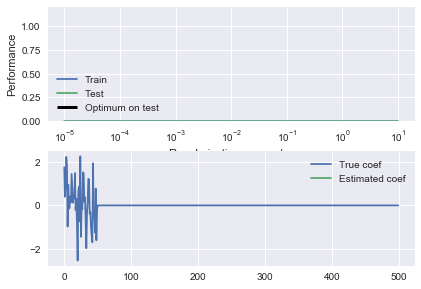

In [689]:
import numpy as np
from sklearn import linear_model

# #############################################################################
# Generate sample data
n_samples_train, n_samples_test, n_features = 75, 150, 500
np.random.seed(0)
coef = np.random.randn(n_features)
coef[50:] = 0.0  # only the top 10 features are impacting the model
# X = np.random.randn(n_samples_train + n_samples_test, n_features)
# y = np.dot(X, coef)

# Split train and test data
# X_train, X_test = X[:n_samples_train], X[n_samples_train:]
# y_train, y_test = y[:n_samples_train], y[n_samples_train:]

# #############################################################################
# Compute train and test errors
alphas = np.logspace(-5, 1, 60)
enet = linear_model.ElasticNet(l1_ratio=0.7)
train_errors = list()
test_errors = list()
for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

i_alpha_optim = np.argmax(test_errors)
alpha_optim = alphas[i_alpha_optim]
print("Optimal regularization parameter : %s" % alpha_optim)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=alpha_optim)
coef_ = enet.fit(X, y).coef_

# #############################################################################
# Plot results functions

import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

# Show estimated coef_ vs true coef
plt.subplot(2, 1, 2)
plt.plot(coef, label='True coef')
plt.plot(coef_, label='Estimated coef')
plt.legend()
plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.26)
plt.show()

In [691]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [697]:
from sklearn.metrics import mean_squared_error, r2_score
predictions=model.predict(y_pred)
rmse=np.sqrt(mean_squared_error(y_test, predictions))
r2=r2_score(y_test, predictions)
print (rmse)
print (r2)

0.201709544499
-2.06483423557


In [699]:
df.columns

Index(['Restaurant Name', 'Zip Code', 'Inspection Date', 'Score',
       'Facility ID', 'Process Description', 'Month', 'Year', 'Day',
       'Pass_Fail'],
      dtype='object')

In [702]:
import patsy

formula='Score ~ Month'
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')

In [704]:
X

,Intercept,Month
0,1.0,8.0
1,1.0,4.0
2,1.0,2.0
3,1.0,3.0
4,1.0,12.0
5,1.0,11.0
6,1.0,2.0
7,1.0,5.0
8,1.0,12.0
9,1.0,3.0


In [105]:
dirties.sort_values(by="Score")


,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day,Dirties
14848,Ichiban at Austin,78757,10/23/2015,36,10215188,Routine Inspection,10,2015,23,False
2867,Crawfish Shack and Oyster Bar,78728,06/16/2016,45,10037846,Routine Inspection,6,2016,16,False
20466,Polvo's Restaurant & Bar,78704,12/23/2015,45,2801085,Routine Inspection,12,2015,23,False
17451,Mikado Ryotei,78758,12/16/2016,50,10617884,Routine Inspection,12,2016,16,False
24487,Taqueria Arandinas,78741,12/12/2014,50,2801526,Routine Inspection,12,2014,12,False
16751,Los Potrillos Restaurant,78753,04/11/2016,50,10796431,Routine Inspection,4,2016,11,False
15463,Joy East,78741,02/26/2015,50,10970056,Routine Inspection,2,2015,26,False
23817,Taqueria Chapala # 5,78741,06/04/2015,51,11252521,Routine Inspection,6,2015,4,False
16185,La Catedral Del Marisco,78702,02/27/2015,53,11077157,Routine Inspection,2,2015,27,False
15790,La Casita Mexican Restaurant,78757,07/07/2016,53,10609544,Routine Inspection,7,2016,7,False


In [29]:
dirtiest[["Restaurant Name", "Score"]].tail()

,Restaurant Name,Score
15463,Joy East,50
16751,Los Potrillos Restaurant,50
17451,Mikado Ryotei,50
20466,Polvo's Restaurant & Bar,45
24487,Taqueria Arandinas,50


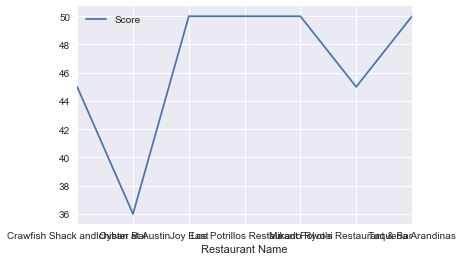

In [34]:
dirtiest.plot("Restaurant Name", "Score")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dd46630>]], dtype=object)

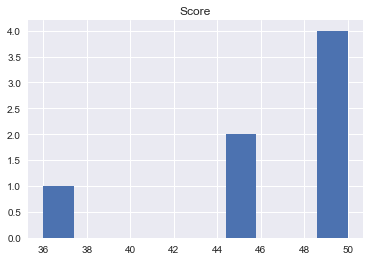

In [35]:
dirtiest.hist("Score")

In [131]:
dirty_dict={"Facility ID": "Restaurant Name"
    }




# sentiment={"subjectivity": [], "polarity": []}

# for i in range(0, df.shape[0]):
#     title_textblob = TextBlob(df["title"].iloc[i])
#     sentiment["subjectivity"].append(title_textblob.sentiment.subjectivity)
#     sentiment["polarity"].append(title_textblob.sentiment.polarity)

In [136]:
# people = [
# {'name': "Tom", 'age': 10},
# {'name': "Mark", 'age': 5},
# {'name': "Pam", 'age': 7}
# ]

filter(lambda restraurant: restaurant['Restraurant Name'] == 'Taco', dirty_dict)

In [101]:
dirties.sort(columns=Score, axis=1, ascending=True,
                inplace=False, kind='quicksort')

AttributeError: 'DataFrame' object has no attribute 'sort'

In [141]:
dirties.describe()

,Zip Code,Score,Facility ID,Month,Year,Day
count,339.000000,339.000000,3.390000e+02,339.000000,339.000000,339.000000
mean,78730.539823,65.876106,7.800239e+06,6.144543,2015.764012,15.587021
std,27.777551,5.622439,3.842896e+06,3.464920,0.928065,8.304163
min,78613.000000,36.000000,2.800024e+06,1.000000,2014.000000,1.000000
25%,78704.000000,63.000000,2.801972e+06,3.000000,2015.000000,9.000000
50%,78741.000000,70.000000,1.023274e+07,6.000000,2016.000000,16.000000
75%,78753.000000,70.000000,1.093639e+07,9.000000,2016.500000,22.000000
max,78759.000000,70.000000,1.159872e+07,12.000000,2017.000000,31.000000


In [175]:
dirties.groupby("Day").count()["Score"].max()

18

In [143]:
day=dirties["Day"]

In [153]:
days=pd.DataFrame(day.value_counts(sort=True, ascending=False))

In [154]:
days

,Day
20,18
8,17
17,16
9,15
29,15
18,15
23,14
14,14
16,14
19,13


In [45]:
df.loc[df['Restaurant Name'].str.contains("Ken's Donuts")].mean()

Score          7.227273e+01
Facility ID    2.800639e+06
dtype: float64

In [49]:
df.groupby(["Restaurant Name", "Score"]).min()

Zip Code Inspection Date  \
Restaurant Name              Score                            
"CB's" at Stubb's Bar-B-Q    97       78701      07/02/2015   
                             99       78701      05/18/2016   
                             100      78701      04/07/2017   
'Bout Time II                83       78752      10/28/2016   
                             89       78752      05/20/2016   
                             92       78752      06/28/2017   
                             94       78752      10/01/2015   
                             100      78752      03/26/2015   
1-Stop Food Store            91       78751      05/18/2016   
                             95       78751      06/07/2017   
                             98       78751      11/07/2016   
                             100      78751      05/15/2015   
15th Street Cafe             86       78701      11/10/2015   
                             91       78701      05/24/2016   
                             93       78701      12/02/2014   
                             97       78701      05/13/2015   
                             99       78701      05/01/2017   
183 Grill Austin Gyros       95       78729      01/28/2016   
1st Food Mart                88       78704      06/20/2017   
                             91       78704      04/18/2016   
                             93       78704      11/14/2016   
                             94       78704      02/09/2015   
2 Dine 4 Fine Catering       86       78702      08/08/2017   
                             87       78702      05/18/2015   
                             92       78702      02/01/2017   
                             95       78702      07/11/2016   
                             98       78702      11/17/2015   
2 n 1 Salad Bar and Grill    96       78758      10/21/2016   
                             97       78758      04/27/2017   
21st St. College House       72       78705      04/25/2016   
...                                     ...             ...   
Zocalo Cafe- Taqueria Fresca 92       78703      10/20/2015   
                             97       78703      01/06/2015   
Zoe's Kitchen                84       78759      05/17/2016   
                             88       78759      06/06/2017   
                             89       78759      06/19/2015   
                             90       78759      01/06/2015   
                             91       78759      12/01/2016   
                             96       78759      12/02/2015   
Zoe's Safe Place             74       78757      09/11/2015   
                             79       78757      01/31/2017   
                             82       78757      09/29/2015   
                             83       78757      09/21/2017   
                             84       78757      08/16/2016   
                             89       78757      02/16/2016   
ZuZu Restaurant              79       78731      03/17/2017   
                             83       78731      09/26/2016   
                             84       78731      03/21/2016   
                             92       78731      04/10/2015   
                             93       78731      09/22/2015   
                             97       78731      12/09/2014   
Zumochi LLC                  98       78745      11/24/2015   
                             99       78745      10/14/2016   
                             100      78745      04/05/2017   
d'lites                      96       78759      04/13/2017   
                             98       78759      04/11/2016   
                             100      78759      10/05/2015   
iFratelli Pizza Arboretum    95       78759      06/19/2017   
iPlay - Austin               93       78748      05/14/2015   
                             96       78748      11/19/2015   
                             100      78748      05/24/2016   

                                                                 

In [52]:
clf_Ridge = linear_model.Ridge(fit_intercept=True, normalize=True, alpha = 0.01) 
clf_Ridge.fit(X_train, y_train)  
clf_Ridge_score = cross_val_score(clf_Ridge,X_train, y_train, cv = 10, scoring = 'r2')
print("The R2 score using for Ridge is %f" % (clf_Ridge_score.mean()))

NameError: name 'X_train' is not defined